<img align="left" src = logos.png width=400 style="padding: 10px"> 
<br>
<b>Investigating Variable Stars in DP0.2</b> <br>
Contact author: Sabina Ustamujic <br>
Last verified to run: 2023-04-14<br>
LSST Science Piplines version: Weekly 2023_07 <br>
Container Size: medium <br>

**Description:** Use catalog data to identify variable stars, plot their lightcurves and calculate their structure function.

**LSST Data Products:** TAP tables dp02_dc2_catalogs.Object, MatchesTruth, TruthSummary, CcdVisit, DiaObject, DiaSource, ForcedSourceOnDiaObject<br>

**Packages:** numpy, matplotlib, lsst.rsp.get_tap_service, pandas, numba

**Credit:** Developed by Sabina Ustamujic. Please consider acknowledging Sabina if this notebook is used for the preparation of journal articles, software releases, or other notebooks. This notebook is based in part on material originally developed by Jeff Carlin, Melissa Graham, Ryan Lau and the Rubin Community Engagement Team for Data Preview 0.

Special thanks to Laura Venuti and Sara Bonito for the support in the analysis.

## 1. Introduction

This notebook demonstrates the use of the TAP service to query the time-domain data products to select variable stars, get their light curves, and calculate their structure functions.

In Section 2 the data products of difference image analysis (DIA), in particular the lightcurve summary statistic parameters available in the `DiaObjects` table, are used to identify a sample of variable stars candidates from the DP0.2 data set and extract their lightcurves using the time-series photometry from `ForcedSourceOnDiaObject` table. Then the coordinates of the identified objects are used to find them in the `Object` table, and check if they are classified as variable stars in the `TruthSummary` table.

In Section 3 the extracted lightcurves for each object are used to calculate their structure functions (SFs). 
The method of SFs (Simonetti et al. 1985 ; Hughes et al. 1992 ; de Vries et al. 2003) was developed to probe the characteristic timescales of variability from lightcurves and it has been more recently implemented to study Young Stellar Objects (YSOs) variability by Sergison et al. (2020) and applied by Venuti et al. (2021).
The method consists of extracting every timescale of variability τ encompassed by the time series and, for each τ, computing the average amplitude of normalized flux variability among all pairs of points in the light curve that are spaced by that time interval τ. The SF is then defined as the average variability amplitude measured within the light curve as a function of τ.

Finally two examples of YSO lightcurves are imported and the SF analysis is performed as was done in the previous section.

### 1.1 Package imports

In [148]:
# General
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

# LSST package for TAP queries
from lsst.rsp import get_tap_service

# SF calculation
import pandas as pd
from numba import njit

### 1.2 Define functions and parameters

Set `matplotlib` to show plots inline, within the notebook.

In [149]:
%matplotlib inline

Set up colors and plot symbols corresponding to the ugrizy bands. These colors are the same as those used for ugrizy bands in Dark Energy Survey (DES) publications, and in most tutorial notebooks.

In [150]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
filters += ['V', 'G', 'R', 'I', 'B']   # added for V2492_Cyg (Section 4)

symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}
symbols.update({'G':'.', 'R':'.', 'I':'.', 'V':'.', 'B':'.'})   # added for V2492_Cyg (Section 4)

colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
          'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
colors.update({'V': '#56b4e9', 'G': '#008060', 'R': '#ff4000', 'I': '#850000', 'B': '#000000'})   # added for V2492_Cyg (Section 4)

Start the TAP service, which we will use for all data retrieval in this notebook.

In [151]:
service = get_tap_service()

## 2. Identify candidate variable stars from Catalogs

Data products from difference image analysis (DIA), where sources are detected and measured on the difference image resulting from subtracting an approriately scaled deep coadd template of the same sky area from a processed visit image (PVI), are a good place to check for variable objects (see 07b Tutorial Notebook).

The three DIA products used here are:

- `DiaObject`: table of all spatially unique objects detected in all difference images (all `DiaSources` associated by coordinate)
- `DiaSource`: table of sources detected in the difference images
- `ForcedSourceOnDiaObject`: table of forced photometry in all PVI and all difference images at the location of all `DiaObjects`

### 2.1 Query DiaObject and ForcedSourceOnDiaObject to Retrieve Candidates and Photometry

The DP0.2 `DiaObject` table contains summary statistics for each object, which can be used to identify candidate variables.

Here are the criteria we apply to our selection from `DiaObject`:

 1. `gTOTFluxSigma`/`gTOTFluxMean` > 0.15 -- the scatter in measured fluxes is larger than 15% relative to the mean
 2. `gPSFluxNdata` > 60 -- at least 60 observations in g band

The query below implements these criteria and performs a table JOIN between `DiaObject` and `ForcedSourceOnDiaObject` to extract the forced-photometry measurements, and between `ForcedSourceOnDiaObject` and `CcdVisit` tables in order to get the MJD of each visit. 

In [152]:
query = "SELECT "\
        "diao.diaObjectId as Object_ID, "\
        "diao.ra as RA, diao.decl as DEC, "\
        "diao.gPSFluxNdata, "\
        "diao.gTOTFluxMean, diao.gTOTFluxSigma, "\
        "fsodo.diaObjectId, "\
        "fsodo.ccdVisitId, "\
        "fsodo.band as Filter, "\
        "fsodo.psfFlux, fsodo.psfFluxErr, "\
        "cv.expMidptMJD as Epoch, "\
        "scisql_nanojanskyToAbMag(fsodo.psfFlux) as Mag "\
        \
        "FROM dp02_dc2_catalogs.DiaObject as diao "\
        "JOIN dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "\
        "ON fsodo.diaObjectId = diao.diaObjectId "\
        "JOIN dp02_dc2_catalogs.CcdVisit as cv ON cv.ccdVisitId = fsodo.ccdVisitId "\
        \
        "WHERE diao.gTOTFluxSigma/diao.gTOTFluxMean > 0.15 "\
        "AND diao.gPSFluxNdata > 60 "


results = service.search(query)
sources = results.to_table().to_pandas()

In [153]:
# Uncomment the following line to view the results table
#sources

The total number of measurements and the number of unique `DiaObjects` found are:

In [154]:
print(len(sources), len(np.unique(sources['Object_ID'])))

6362 14


In [155]:
# Uncomment the following line to save the pandas DataFrame to a pickle file
#sources.to_pickle("my_sources.pkl")

In [156]:
# Uncomment the following line to read the pandas DataFrame from the pickle file
#candidate_sources = pd.read_pickle("my_sources.pkl")

### 2.2 Query Truth Tables to check if the retrieved candidates are variable stars

For each one of the variable candidates retrieved in Sec. 2.1, query the `Object` table for the position (RA, DEC) of the Object of interest to find the ObjectID, specifying a very small area to search (0.001 degrees) to retrieve only the Object of interest.

Then the ObjectID can be used to pick out the characteristics of interest from the Truth Tables (by use of a WHERE statement in the query and joining different tables).
The `MatchesTruth` table provides identifying information to pick out objects that have matches to truth objects, and extract the simulated truth values from the `TruthSummary` table. This requires joining all three tables (`Object`, `MatchesTruth`, `TruthSummary`).

In [157]:
sources_obj = pd.DataFrame()   # new DataFrame

for objID in sources['Object_ID'].unique():   # for all Objects retrieved in Sec. 2.1
    print(objID)
    source_sel = sources[sources['Object_ID']==objID].iloc[0]   # select the first one
    RA_sel = source_sel['RA']
    DEC_sel = source_sel['DEC']
    
    query = "SELECT TOP 100 \n"\
            "obj.coord_ra, obj.coord_dec, obj.objectId, \n"\
            "ts.truth_type, ts.is_variable, ts.is_pointsource, \n"\
            "obj.detect_isPrimary, \n"\
            "obj.refBand, obj.refExtendedness, \n"\
            "mt.id_truth_type, mt.match_objectId \n"\
            \
            "FROM dp02_dc2_catalogs.MatchesTruth AS mt \n"\
            "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type \n"\
            "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId \n"\
            \
            "WHERE CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), \n"\
            f"CIRCLE('ICRS', {RA_sel}, {DEC_sel}, 0.001)) = 1 \n"\
            "AND detect_isPrimary = 1"

    results = service.search(query)
                    
    new_objs = results.to_table().to_pandas()
    sources_obj = pd.concat([sources_obj, new_objs], ignore_index=True)   # new resulting DataFrame

2186576783925575723
2186585580018597908
2186647152669753375
2186576783925575777
2186963812018552907
2186972608111575078
2186726317506953221
2094534466541191272
2186629560483709003
2186567987832553525
2187042976855752738
2187104549506908257
2187042976855752730
2187034180762730596


In [158]:
# View the results table
sources_obj

,coord_ra,coord_dec,objectId,truth_type,is_variable,is_pointsource,detect_isPrimary,refBand,refExtendedness,id_truth_type,match_objectId
0,70.153595,-27.968700,2186576783925612165,2,1,1,True,y,1.0,459369163_2,2186576783925612165
1,70.036383,-27.983681,2186585580018631574,2,1,1,True,z,1.0,1247438252_2,2186585580018631574
2,70.045515,-27.686186,2186647152669795694,2,1,1,True,y,1.0,459364478_2,2186647152669795694
3,70.284804,-28.061184,2186576783925603246,2,1,1,True,u,1.0,453525504_2,2186576783925603246
4,71.363070,-28.208727,2186963812018586106,2,1,1,True,z,1.0,459376303_2,2186963812018586106
5,70.973895,-28.086954,2186972608111619905,2,1,1,True,g,1.0,1247455826_2,2186972608111619905
6,69.534812,-27.431116,2186726317506996535,2,1,1,True,z,1.0,1568758256_2,2186726317506996535
7,70.909205,-28.776105,2094534466541229030,2,1,1,True,y,1.0,459383075_2,2094534466541229030
8,70.382288,-27.844387,2186629560483734313,2,1,1,True,z,1.0,1247434323_2,2186629560483734313
9,70.342809,-28.018164,2186567987832584164,2,1,1,True,y,1.0,969668112_2,2186567987832584164


All the 14 candidates are classified as variable stars and point sources.

In [159]:
# Uncomment the following line to save the pandas DataFrame to a pickle file
#sources_obj.to_pickle("my_sources_obj.pkl")

In [160]:
# Uncomment the following line to read the pandas DataFrame from the pickle file
#truth_sources = pd.read_pickle("my_sources_obj.pkl")

In [161]:
# We define a catalog using the 14 sources retrived in Sec. 2.1 including all the necessary data for our SF analysis
catalog_df = sources[['Object_ID', 'Epoch', 'Mag', 'Filter']]
print(catalog_df)

                Object_ID         Epoch        Mag Filter
0     2186576783925575723  60767.006912  16.171037      g
1     2186576783925575723  60587.223138  15.959734      i
2     2186576783925575723  60214.330659  15.344794      z
3     2186576783925575723  61327.361133  16.190616      g
4     2186576783925575723  60777.973824  15.339614      z
...                   ...           ...        ...    ...
6357  2187034180762730596  59904.077113  17.402224      u
6358  2187034180762730596  60514.432430  15.500810      z
6359  2187034180762730596  60692.093215  17.347182      r
6360  2187034180762730596  60393.033890  15.472504      y
6361  2187034180762730596  60541.360553  15.477150      y

[6362 rows x 4 columns]


## 3. Structure Functions Analysis

### 3.1 Define the functions implemented for the SFs analysis

The implemented functions are:

- **data_summary:** Gives a summary of the data used for the analysis
- **calcSF:** Calculates the structure function
- **SF_analysis:** Performs structure function analysis checking the data, calculating the SF (using calcSF) and plotting the results

In [162]:
### Data summary

def data_summary(df):
    objects = df['Object_ID'].unique()   # list of unique object IDs
    print(f"Objects number = {objects.size}")

    print('')
    print(f"Objects list:", end=" ")
    for obj in objects:
        print(f"\n{obj}:", end=" ")
        obj_data_all = df[df['Object_ID'] == obj]   # select only data related to the object
        for filt in filters:
            obj_data_filter = obj_data_all[obj_data_all['Filter'] == filt]   # select only data related to the filter
            if not obj_data_filter.empty:
                print(f"{filt} ({len(obj_data_filter):3})", end=" ")
    print('')

In [164]:
### Calculate structure function

@njit   # accelerate the calculations
def calcSF(taumin,taumax,tclip,fclip,nstep):
    dtau = (np.log10(taumax) - np.log10(taumin))/nstep

    tau1 = np.zeros(nstep)
    tau2 = np.zeros(nstep)
    N = np.zeros(nstep)
    SF = np.zeros(nstep)

    for k in range(nstep):
        tau1[k] = 10**(np.log10(taumin) + k*dtau)
        tau2[k] = 10**(np.log10(tau1[k]) + dtau)
        for i in range(tclip.size):
            # Sliced
            dist = tclip[i:] - tclip[i]
            sel = (dist >= tau1[k]) & (dist < tau2[k])
            N[k] += tclip[i:][sel].size
            if tclip[i:][sel].size > 0:
                SF[k] += np.sum((fclip[i:][sel] - fclip[i])**2)
        SF[k] = np.sqrt(SF[k] / N[k]) if N[k]>0 else np.nan
    return(tau1,tau2,SF,N)
            

In [165]:
### Structure function analysis (calls calcSF function)    

def SF_analysis(df,nstep=200,Nmin=10):
    objects = df['Object_ID'].unique()   # list of unique object IDs
    
    for obj in objects:
        fig_lc, ax_lc = plt.subplots(figsize=(10,5))   # size of figures
        ax_lc.set_title(f'{obj}')
        fig_sf, ax_sf = plt.subplots(figsize=(10,5))
        ax_sf.set_title(f'{obj}')

        obj_data_all = df[df['Object_ID'] == obj]   # select only data related to the object

        for filt in filters:
            obj_data_filter = obj_data_all[obj_data_all['Filter'] == filt]   # select only data related to the filter
            if obj_data_filter.empty: continue
            obj_data_filter = obj_data_filter.drop_duplicates(subset='Epoch', keep='first')   # drop rows with duplicated time (leaves the first one)
            obj_data_filter.sort_values(by=['Epoch'], inplace=True)
            obj_data = obj_data_filter[obj_data_filter['Mag'] > 0]   # select only rows with flux > 0
            count = obj_data['Mag'].count()
            count_init = count
            count_old = count+1   # force entering clipping loop 
            excluded_points = [[],[]]
            while(count_old-count > 0):   # iteratively select only data with flux within 5*sigma
                mag_mean = obj_data['Mag'].mean()   # calculate flux average
                mag_std = obj_data['Mag'].std(ddof=1)   # calculate standard deviation (norm with N-1)
                print(f"{obj}, {filt}: count={count}; mean={mag_mean}; std={mag_std}",end=', ')
                obj_data_excluded = obj_data[np.abs(obj_data['Mag']-mag_mean) >= 5*mag_std]
                excluded_points[0] += obj_data_excluded['Epoch'].to_list()
                excluded_points[1] += obj_data_excluded['Mag'].to_list()
                obj_data = obj_data[np.abs(obj_data['Mag']-mag_mean) < 5*mag_std]   # select only data with flux within 5*sigma
                count_old = count
                count = obj_data['Mag'].count()
                print(f"count after clipping: {count}")
            mag_mean = obj_data['Mag'].mean()   # calculate flux average
            mag_std = obj_data['Mag'].std(ddof=1)   # calculate standard deviation (norm with N-1)
            print(f"Init. count={count_init:5d}; clip count={count:5d}; mean={mag_mean:.6f}; std={mag_std:.6f}")

            # Uncomment to print the excluded points
            #if len(excluded_points[0]) > 0:
            #    print(f"Excluded points: {np.array(excluded_points[0]),excluded_points[1]}")

            if obj_data.empty: continue

            tclip = obj_data['Epoch'].to_numpy()
            fclip = obj_data['Mag'].to_numpy()
            fclip = 10**(-0.4*(fclip-np.median(fclip)))   # convert magnitudes to fluxes

            dtmin = np.min(np.diff(tclip))
            dtmax = tclip[-1]-tclip[0] 

            print(f"Minimum time lag is {dtmin:.6f}, maximum time lag is {dtmax:.6f}")

            taumin = 2.*dtmin
            taumax = 0.5*dtmax

            print(f"Minimum considered time lag is {taumin:.6f}, maximum considered time lag is {taumax:.6f}")

            tau1,tau2,SF,N = calcSF(taumin,taumax,tclip,fclip,nstep)

            print('')
            
            # Uncomment to save the output
            #np.savetxt('out_'+obj+'_'+filt+'.txt', np.c_[tau1, tau2, SF, N], delimiter='\t',header="tau1, tau2, SF, N")

            ax_lc.plot(obj_data['Epoch'], obj_data['Mag'], label=filt, color=colors[filt], marker=symbols[filt], linewidth=0)
            # Uncomment to plot the excluded points
            #if len(excluded_points[0]) > 0:
            #    ax_lc.plot(np.array(excluded_points[0]),excluded_points[1],'+',label=filt,color=colors[filt])
            ax_sf.loglog(tau1[N>Nmin], SF[N>Nmin], label=filt, color=colors[filt], marker=symbols[filt], linewidth=0)

        ax_lc.set_xlabel("MJD")
        ax_lc.set_ylabel("Mag")
        ax_lc.invert_yaxis()
        ax_lc.grid(True)
        ax_lc.legend()

        ax_sf.set_xlabel("tau1")
        ax_sf.set_ylabel("SF(tau1,tau2)")
        ax_sf.grid(True)
        ax_sf.legend()

        print('-'*99)

    plt.show()


### 3.2 Application to the variable stars selected from the DP0.2 Catalogs

Apply the SF analysis to the data retrieved in Section 2.

In [166]:
## How the data looks like (ObjectsID, Filters and Number of points)
data_summary(catalog_df)

Objects number = 14

Objects list: 
2186576783925575723: u ( 30) g ( 68) r (102) i (103) z ( 62) y ( 82) 
2186585580018597908: u ( 30) g ( 63) r (104) i (111) z ( 69) y ( 84) 
2186647152669753375: u ( 32) g ( 63) r ( 99) i (115) z ( 74) y ( 88) 
2186576783925575777: u ( 28) g ( 67) r ( 99) i ( 97) z ( 63) y ( 83) 
2186963812018552907: u ( 25) g ( 67) r (105) i (107) z ( 59) y ( 88) 
2186972608111575078: u ( 29) g ( 65) r (109) i (109) z ( 60) y ( 84) 
2186726317506953221: u ( 33) g ( 64) r (115) i (117) z ( 88) y ( 83) 
2094534466541191272: u ( 29) g ( 65) r (100) i ( 98) z ( 58) y ( 85) 
2186629560483709003: u ( 25) g ( 63) r ( 98) i ( 94) z ( 64) y ( 82) 
2186567987832553525: u ( 25) g ( 66) r ( 96) i (103) z ( 59) y ( 86) 
2187042976855752738: u ( 26) g ( 63) r (110) i (109) z ( 58) y ( 81) 
2187104549506908257: u ( 27) g ( 66) r (117) i (109) z ( 62) y ( 83) 
2187042976855752730: u ( 32) g ( 62) r (111) i (103) z ( 58) y ( 92) 
2187034180762730596: u ( 32) g ( 63) r (117) i (108) z

Calculate the SF for each Object and Filter, and plot both the input lightcurve and the output SF.

2186576783925575723, u: count=30; mean=17.607024105379768; std=0.0041765746024282745, count after clipping: 30
Init. count=   30; clip count=   30; mean=17.607024; std=0.004177
Minimum time lag is 0.000446, maximum time lag is 1737.166696
Minimum considered time lag is 0.000892, maximum considered time lag is 868.583348

2186576783925575723, g: count=68; mean=16.309777730806886; std=0.29010346571036116, count after clipping: 68
Init. count=   68; clip count=   68; mean=16.309778; std=0.290103
Minimum time lag is 0.000447, maximum time lag is 1751.160660
Minimum considered time lag is 0.000894, maximum considered time lag is 875.580330

2186576783925575723, r: count=102; mean=16.16821986843726; std=0.562080721215598, count after clipping: 102
Init. count=  102; clip count=  102; mean=16.168220; std=0.562081
Minimum time lag is 0.000446, maximum time lag is 1567.779528
Minimum considered time lag is 0.000892, maximum considered time lag is 783.889764

2186576783925575723, i: count=103; m

/tmp/ipykernel_796/1553887462.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_lc, ax_lc = plt.subplots(figsize=(10,5))   # size of figures


2187042976855752738, u: count=26; mean=18.285351383261155; std=0.008086923379341316, count after clipping: 26
Init. count=   26; clip count=   26; mean=18.285351; std=0.008087
Minimum time lag is 0.000448, maximum time lag is 1796.990459
Minimum considered time lag is 0.000896, maximum considered time lag is 898.495229

2187042976855752738, g: count=63; mean=16.286183643884563; std=0.2330481610854077, count after clipping: 63
Init. count=   63; clip count=   63; mean=16.286184; std=0.233048
Minimum time lag is 0.000446, maximum time lag is 1751.185622
Minimum considered time lag is 0.000892, maximum considered time lag is 875.592811

2187042976855752738, r: count=110; mean=16.29518764744112; std=0.664613288736452, count after clipping: 110
Init. count=  110; clip count=  110; mean=16.295188; std=0.664613
Minimum time lag is 0.000447, maximum time lag is 1567.780453
Minimum considered time lag is 0.000894, maximum considered time lag is 783.890226

2187042976855752738, i: count=109; mea

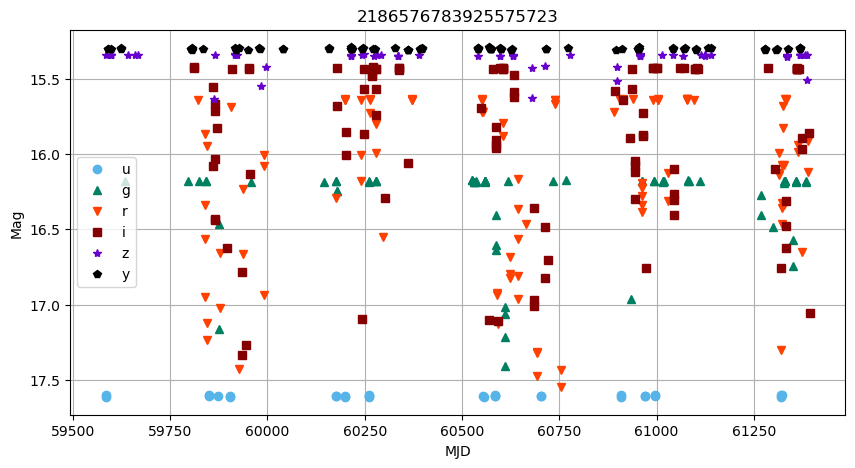

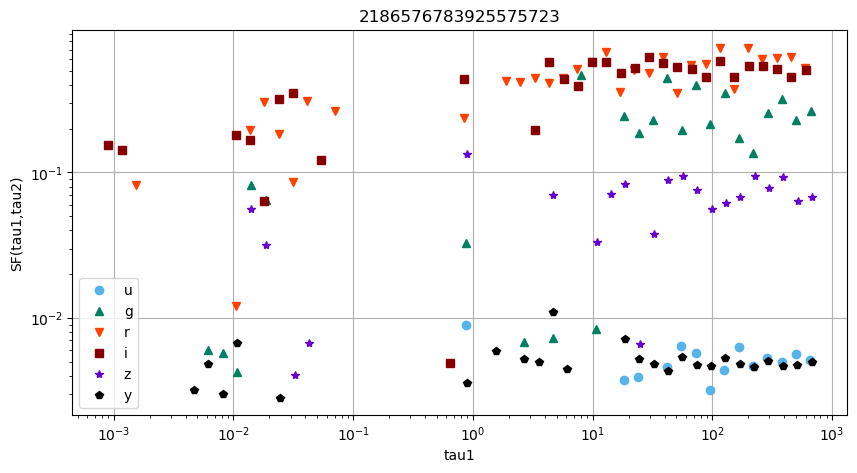

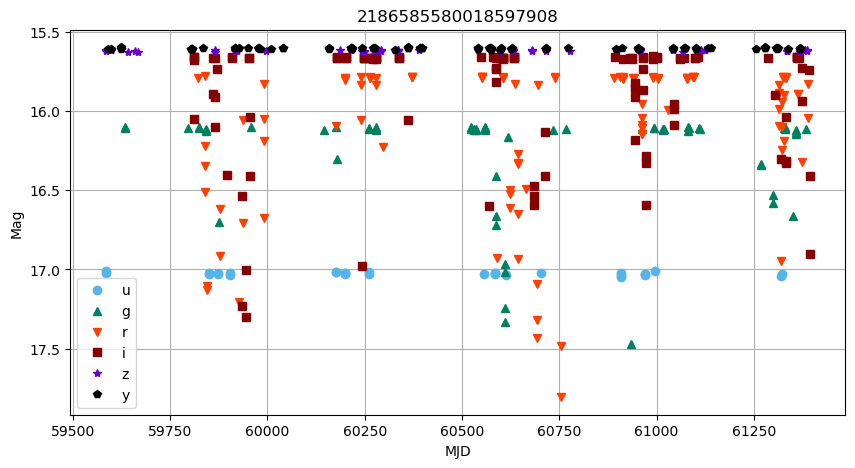

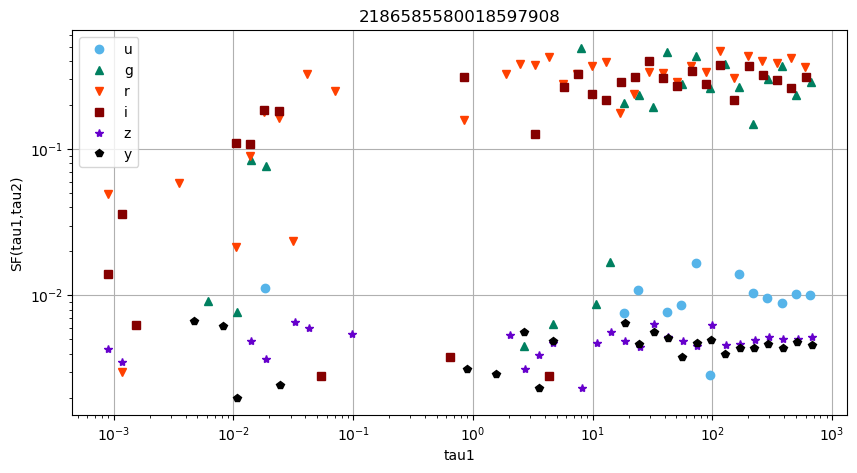

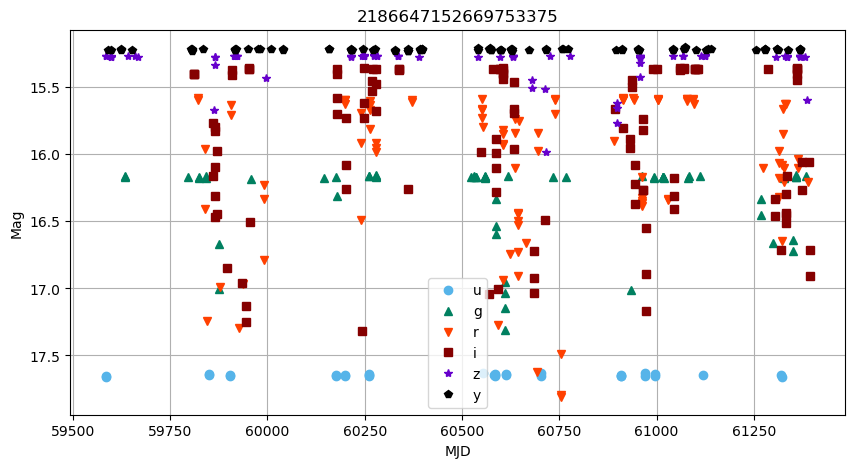

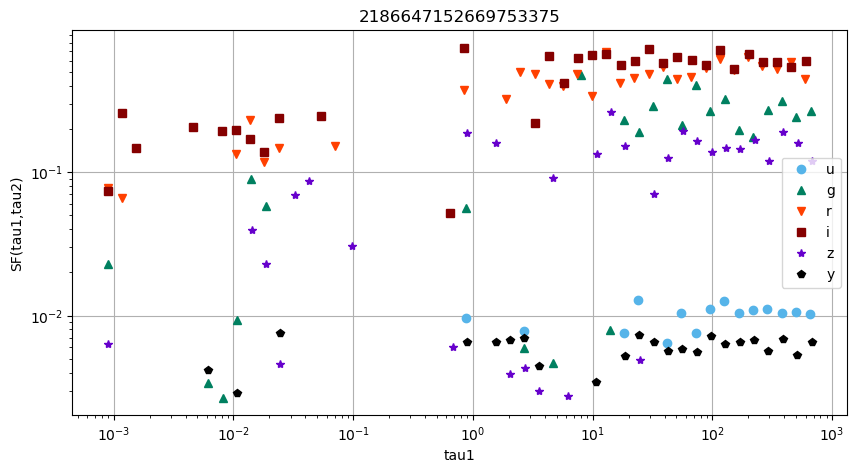

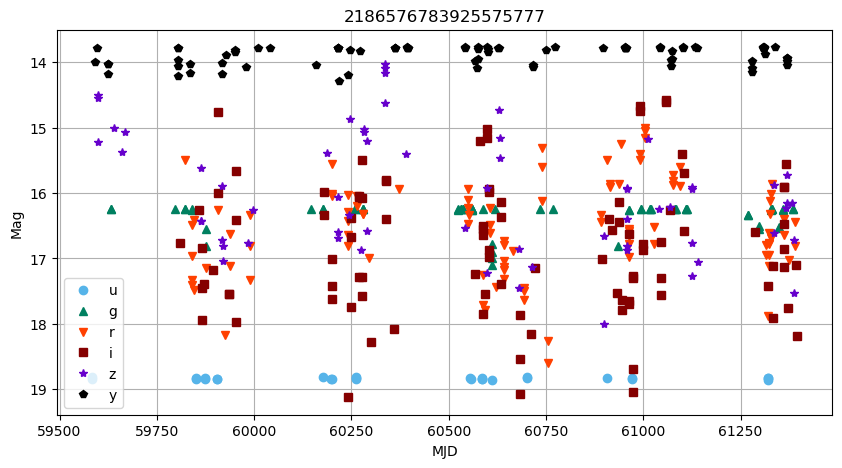

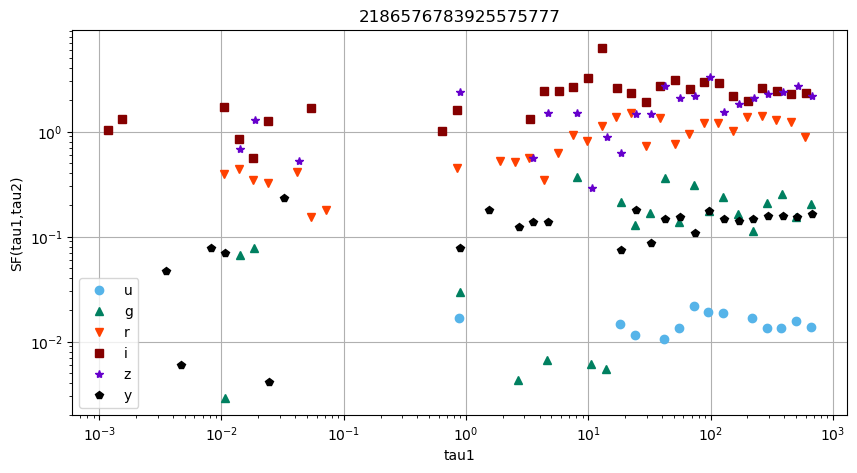

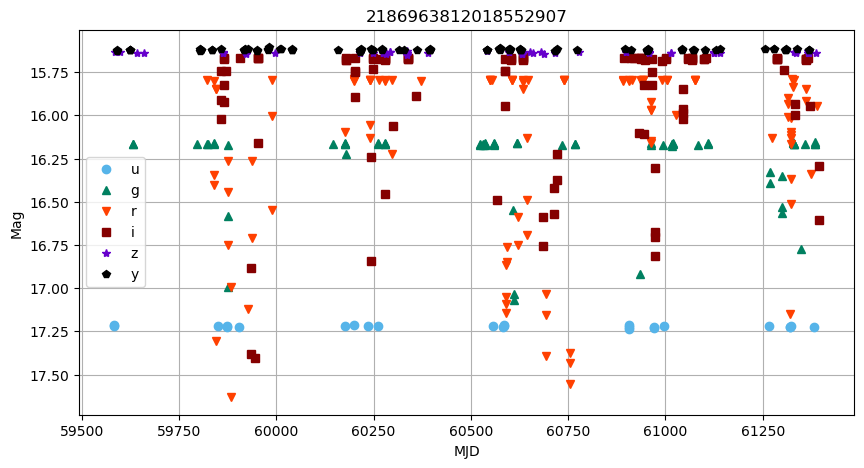

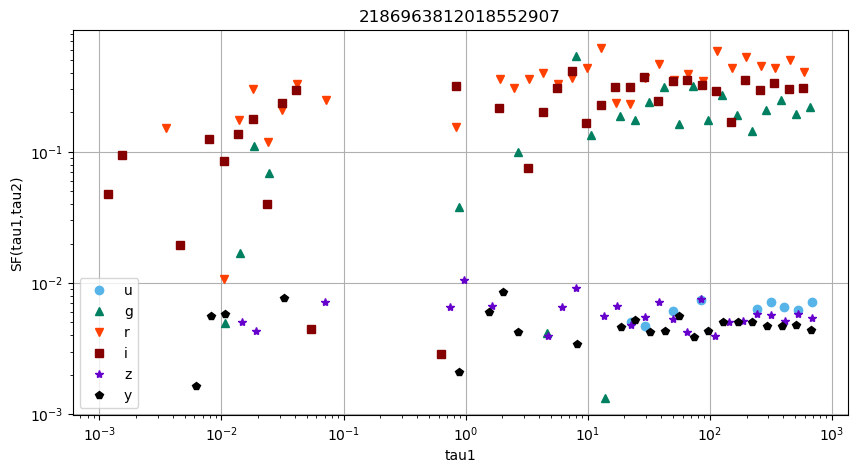

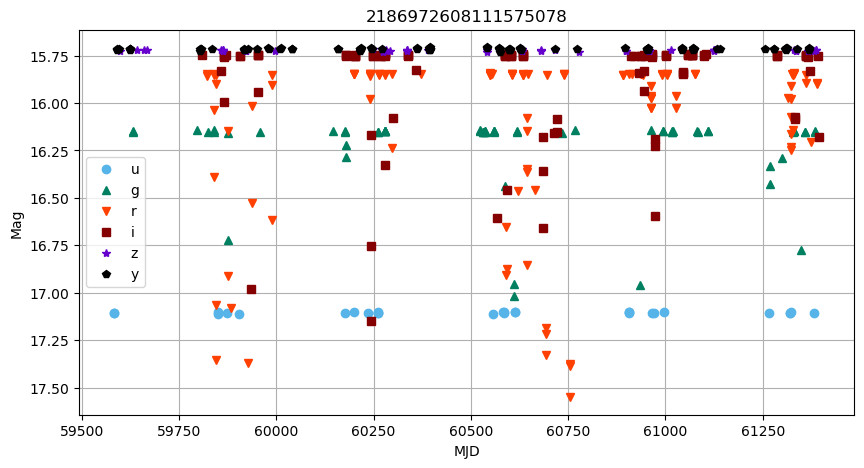

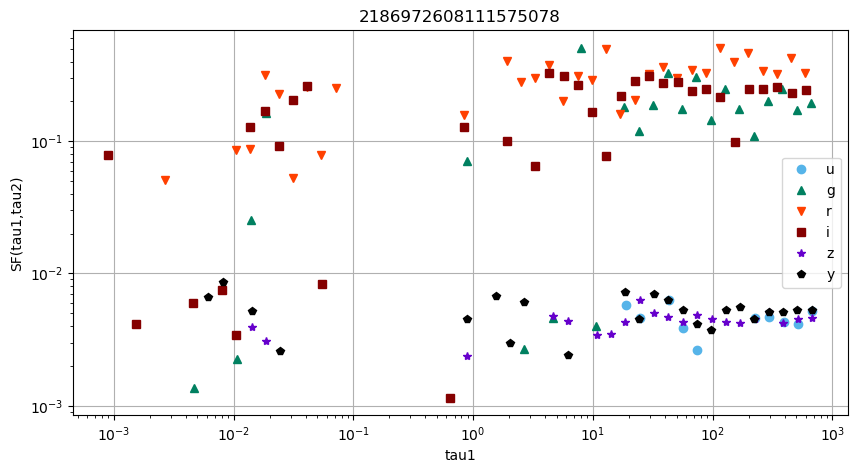

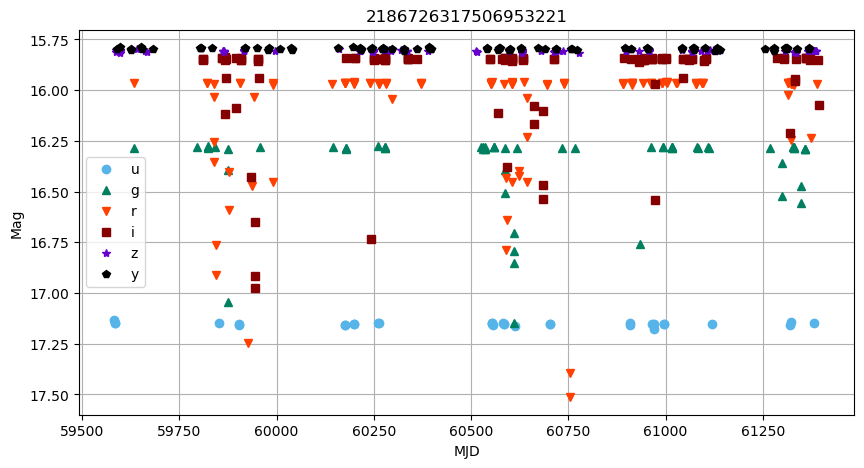

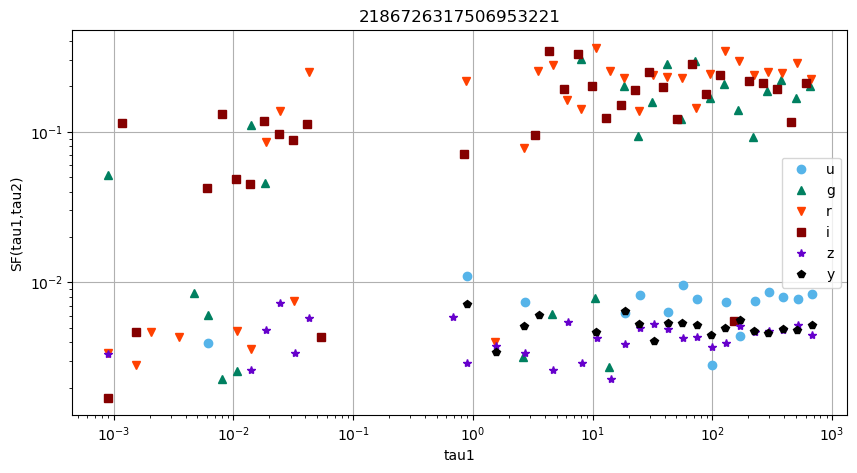

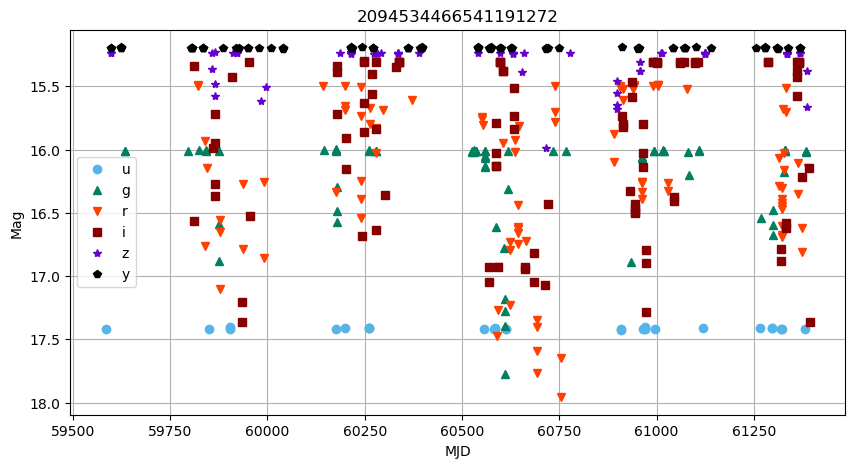

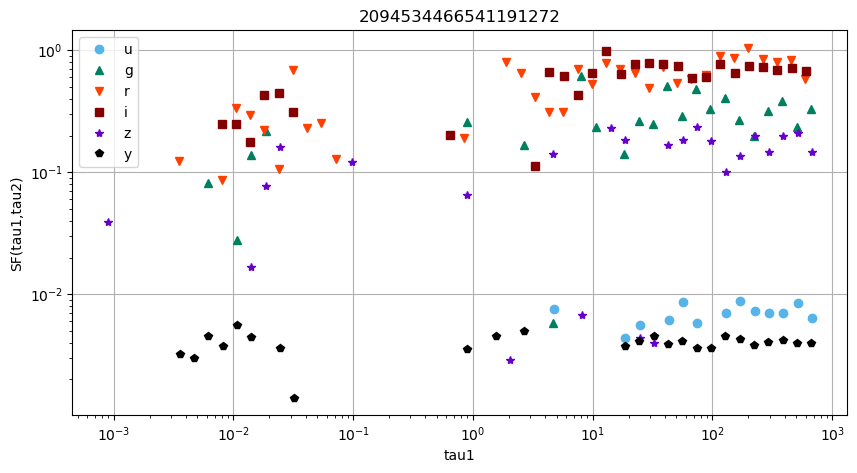

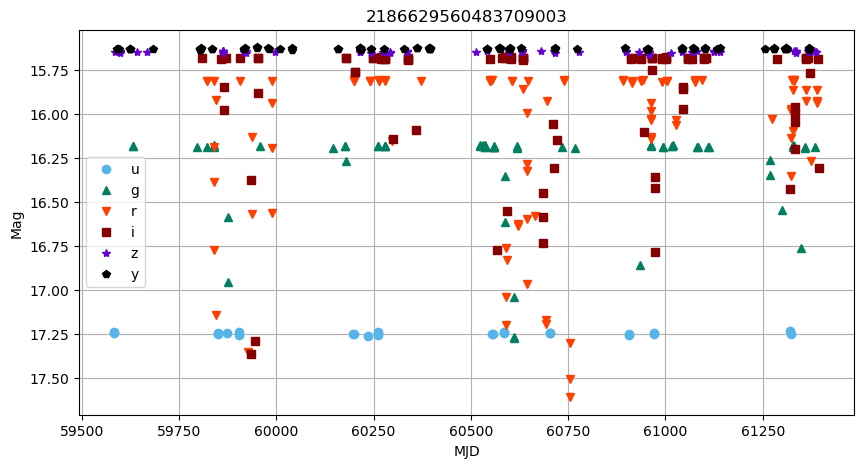

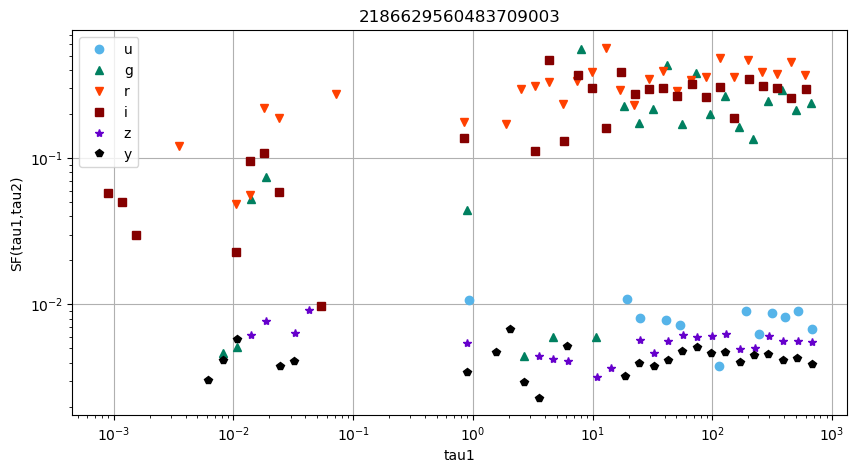

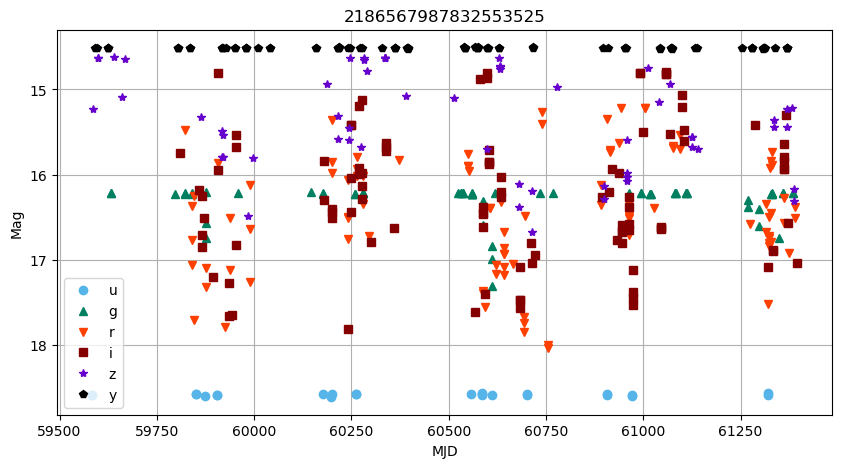

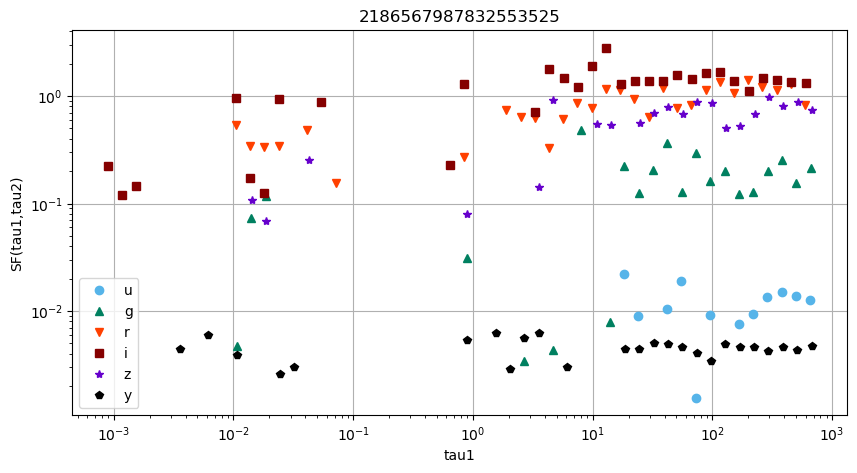

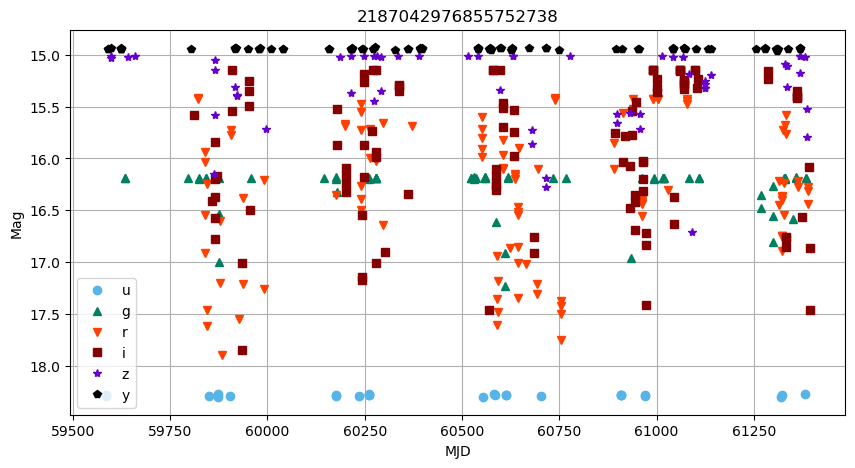

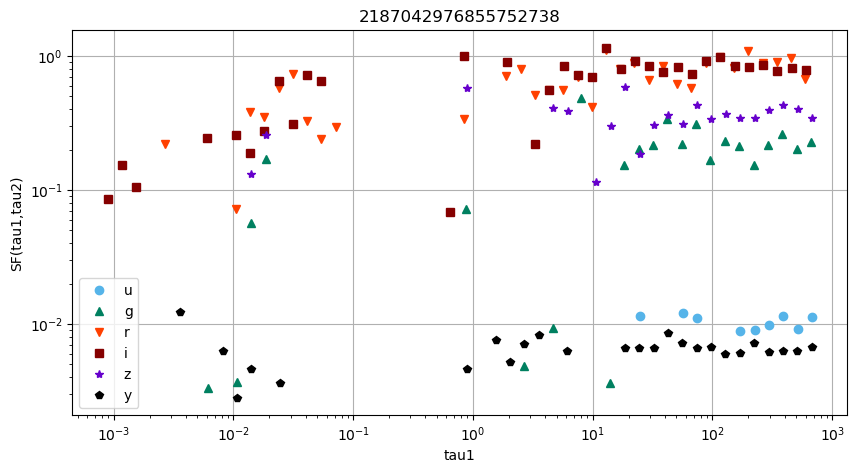

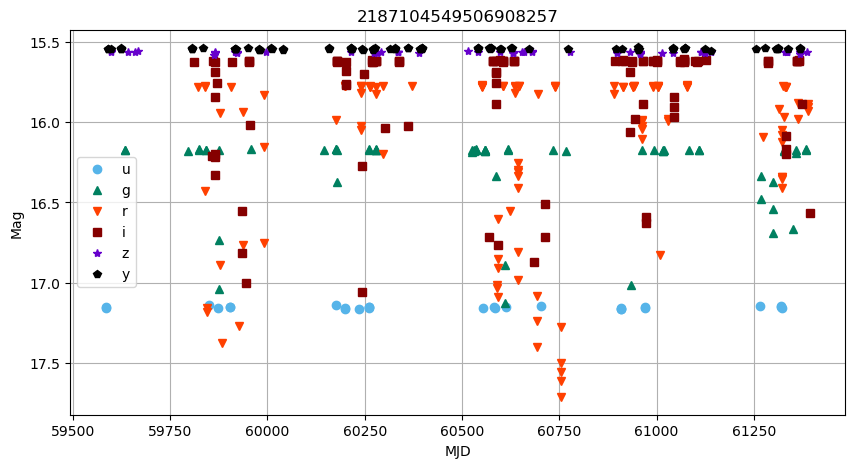

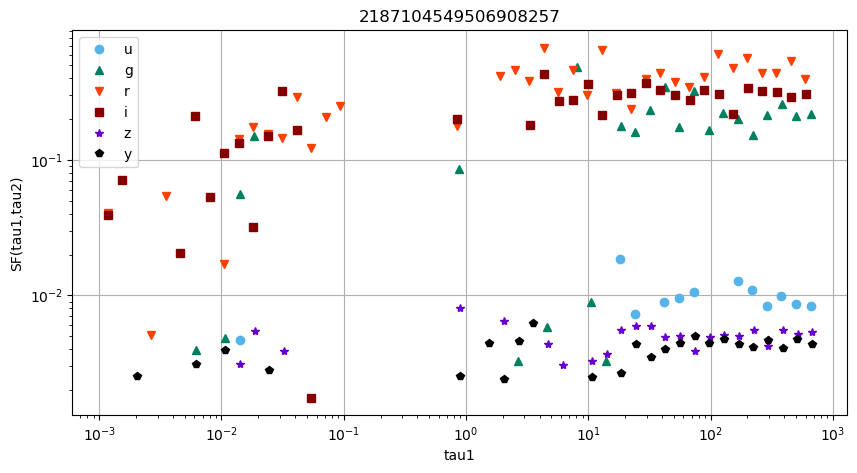

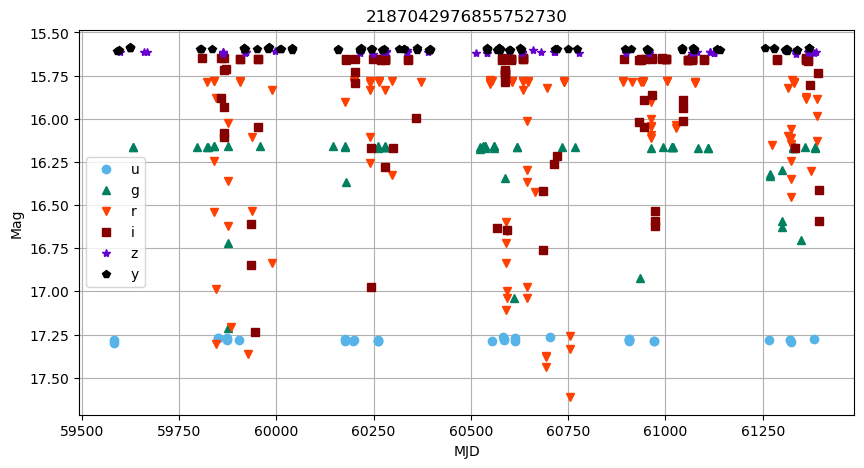

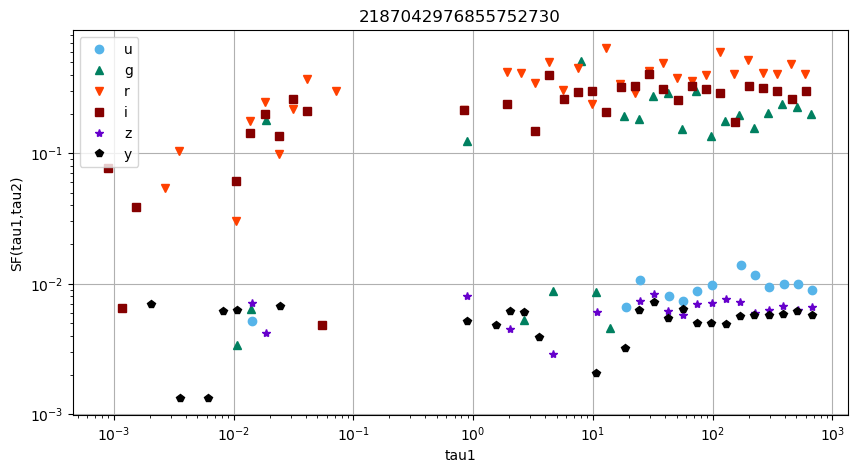

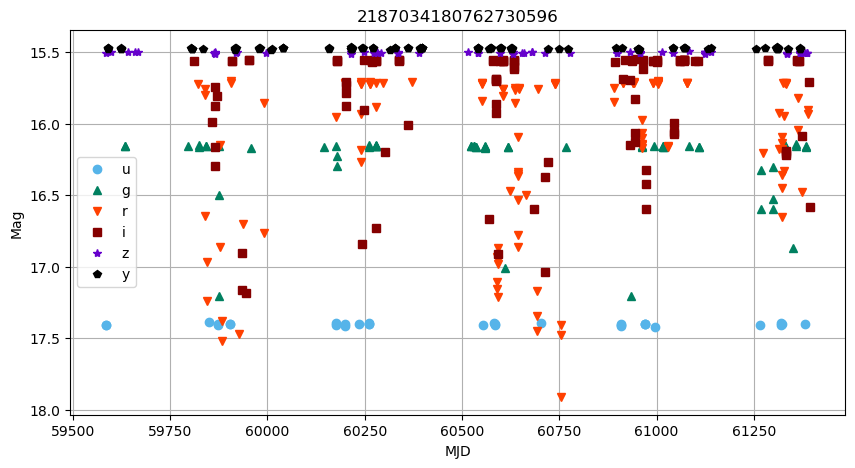

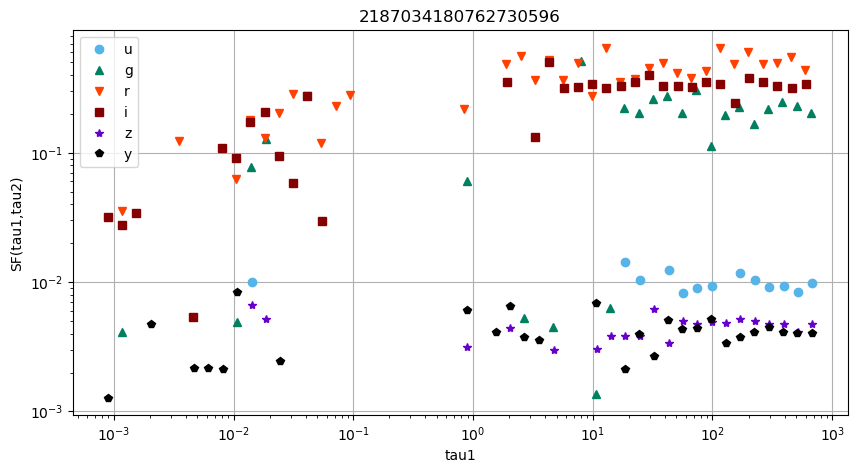

In [167]:
SF_analysis(catalog_df,nstep=50,Nmin=2)

### 3.3 Application to two examples of variable YSOs

Apply the SF analysis to Mon-63 (in NGC2264) and to V2492_Cyg (EXor) reading the datafiles provided in the current folder.

In [168]:
## Read data file
datafile = "NGC2264_Mon-63_lc.txt"
Mon63_df = pd.read_csv(datafile, sep='\t', header=0)   # import data as pandas dataframe
#print(Mon63_df)

In [169]:
## Data summary
data_summary(Mon63_df)

Objects number = 1

Objects list: 
Mon-63: g (240) r (847) i ( 15) z ( 12) y ( 17) 


Calculate the SF for each Filter, and plot both the input lightcurve and the output SF.

Mon-63, g: count=240; mean=18.755954860291165; std=0.1590827678620516, count after clipping: 239
Mon-63, g: count=239; mean=18.760929369668364; std=0.13946228234190325, count after clipping: 239
Init. count=  240; clip count=  239; mean=18.760929; std=0.139462
Minimum time lag is 0.004039, maximum time lag is 3986.772012
Minimum considered time lag is 0.008079, maximum considered time lag is 1993.386006

Mon-63, r: count=847; mean=17.22626658501172; std=0.10363231563254832, count after clipping: 843
Mon-63, r: count=843; mean=17.226160240531424; std=0.09548007227960126, count after clipping: 842
Mon-63, r: count=842; mean=17.225591984516118; std=0.09409964540254667, count after clipping: 842
Init. count=  847; clip count=  842; mean=17.225592; std=0.094100
Minimum time lag is 0.000336, maximum time lag is 3691.758930
Minimum considered time lag is 0.000671, maximum considered time lag is 1845.879465

Mon-63, i: count=15; mean=16.203774753081305; std=0.09836366433471648, count after cli

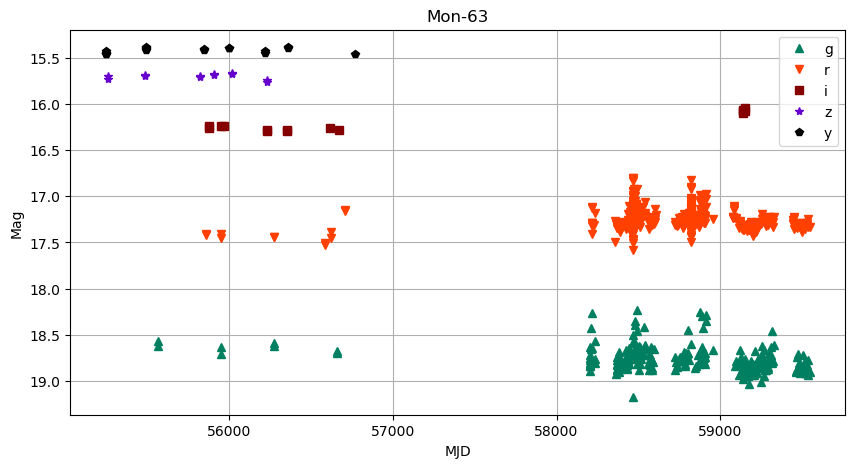

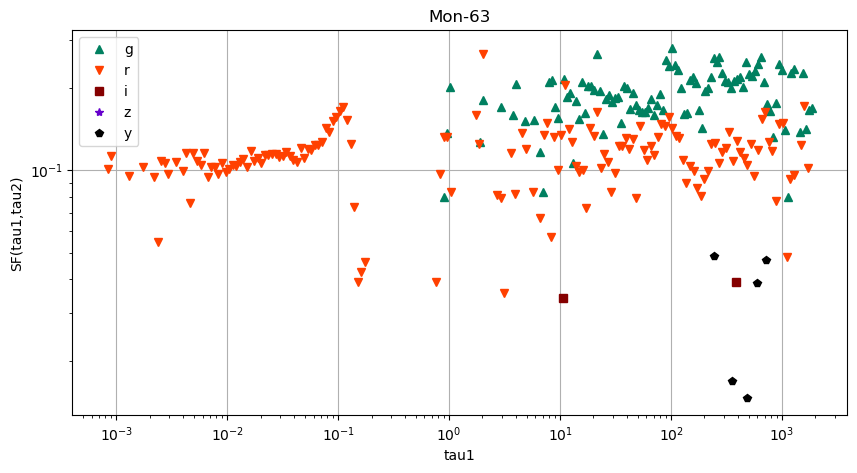

In [175]:
SF_analysis(Mon63_df,Nmin=5)

In [176]:
## Read data file
datafile = "V2492_Cyg_lc.txt"
V2492Cyg_df = pd.read_csv(datafile, sep='\t', header=0)   # import data as pandas dataframe (EXor)
#print(V2492Cyg_df)

In [178]:
## Data summary
data_summary(V2492Cyg_df)

Objects number = 1

Objects list: 
V2492_Cyg: V (1878) G ( 78) R (667) I (819) B (288) 


Calculate the SF for each Filter, and plot both the input lightcurve and the output SF.

V2492_Cyg, V: count=1874; mean=15.8856227321238; std=1.0543956086075763, count after clipping: 1874
Init. count= 1874; clip count= 1874; mean=15.885623; std=1.054396
Minimum time lag is 0.000010, maximum time lag is 3977.045050
Minimum considered time lag is 0.000020, maximum considered time lag is 1988.522525

V2492_Cyg, G: count=78; mean=15.695512820512821; std=2.066916046043463, count after clipping: 78
Init. count=   78; clip count=   78; mean=15.695513; std=2.066916
Minimum time lag is 0.074000, maximum time lag is 2617.545220
Minimum considered time lag is 0.148000, maximum considered time lag is 1308.772610

V2492_Cyg, R: count=666; mean=15.62804354354354; std=1.3931387560432842, count after clipping: 666
Init. count=  666; clip count=  666; mean=15.628044; std=1.393139
Minimum time lag is 0.000160, maximum time lag is 3693.019570
Minimum considered time lag is 0.000320, maximum considered time lag is 1846.509785

V2492_Cyg, I: count=819; mean=13.793483516483516; std=1.189280563

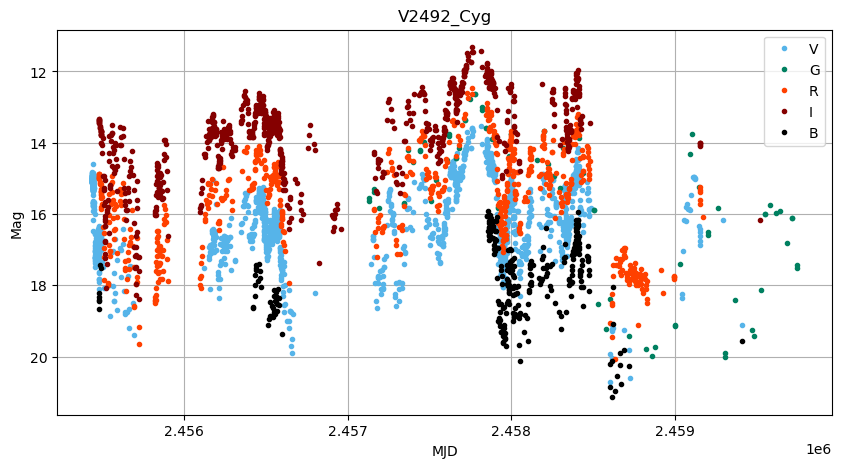

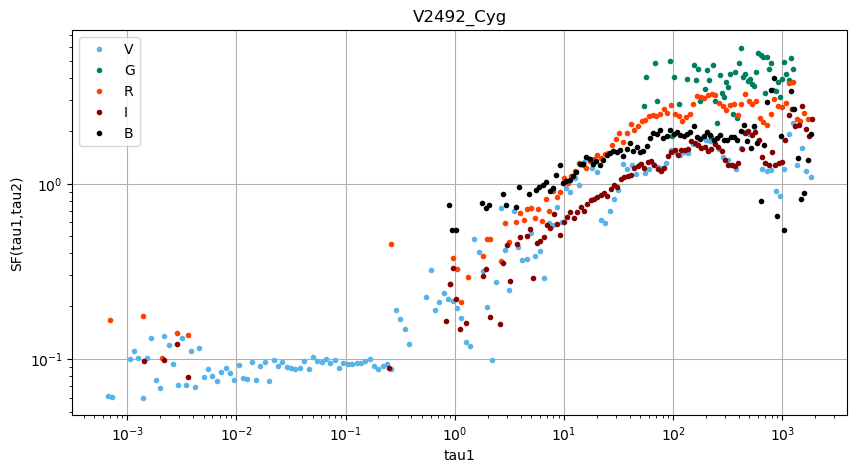

In [179]:
SF_analysis(V2492Cyg_df)

## 4. Continue exploring the data

There are many further explorations one could try as extensions of this notebook. Some examples:

1. Experiment with ways to select the variable objects in the Catalogs.
2. Try to apply the SF analysis to other variable objects.
3. Explore how the calculated SF changes when varying the nstep input parameter.
4. Extract the characteristic statistical values for the SFs calculated.
